In [1]:
!pip install mtcnn
!pip install --quiet kaggle
!pip install opendatasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import cv2
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
import opendatasets as od
import json
import os
import matplotlib.pyplot as plt
import joblib
from random import choice
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

np.random.seed(42)

# **Read Datasets from Kaggle**

In [3]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.kaggle'

import shutil
shutil.move('/content/kaggle(5)(1)(4)(1).json', '/root/.kaggle/kaggle.json')

from kaggle.api.kaggle_api_extended import KaggleApi


api = KaggleApi()
api.authenticate()

api.dataset_download_files('robinreni/signature-verification-dataset', path='.', unzip=True)
api.dataset_download_files('shirazumlintraminhaghjou/signature-verification-dataset-iraninan', path='.', unzip=True)
api.dataset_download_files('saurabstha5/signature-forgery-dataset', path='.', unzip=True)
print("Dataset downloaded and extracted!")


Dataset URL: https://www.kaggle.com/datasets/robinreni/signature-verification-dataset
Dataset URL: https://www.kaggle.com/datasets/shirazumlintraminhaghjou/signature-verification-dataset-iraninan
Dataset URL: https://www.kaggle.com/datasets/saurabstha5/signature-forgery-dataset


ApiException: (403)
Reason: Forbidden
HTTP response headers: HTTPHeaderDict({'Content-Type': 'application/json', 'Date': 'Thu, 30 Jan 2025 16:09:21 GMT', 'Access-Control-Allow-Credentials': 'true', 'Access-Control-Allow-Origin': '*', 'Set-Cookie': 'ka_sessionid=c767dc98eed148cde8c9535c4ffb14b7; max-age=2626560; path=/, GCLB=CPfztomQm6Tm8wEQAw; path=/; HttpOnly', 'Vary': 'Accept-Encoding', 'X-Kaggle-MillisecondsElapsed': '4', 'X-Kaggle-RequestId': 'b865a5b07ae8e19e6499e87aba2e4b07', 'X-Kaggle-ApiVersion': '1.6.17', 'X-Kaggle-HubVersion': '0.3.6', 'X-Frame-Options': 'SAMEORIGIN', 'Strict-Transport-Security': 'max-age=63072000; includeSubDomains; preload', 'Content-Security-Policy': "object-src 'none'; script-src 'nonce-qWC76nV32F/rE4uogDYJWw==' 'report-sample' 'unsafe-inline' 'unsafe-eval' 'strict-dynamic' https: http:; base-uri 'none'; report-uri https://csp.withgoogle.com/csp/kaggle/20201130; frame-src 'self' https://www.kaggleusercontent.com https://www.youtube.com/embed/ https://polygraph-cool.github.io https://www.google.com/recaptcha/ https://www.docdroid.com https://www.docdroid.net https://kaggle-static.storage.googleapis.com https://kkb-production.jupyter-proxy.kaggle.net https://kkb-production.firebaseapp.com https://kaggle-metastore.firebaseapp.com https://apis.google.com https://content-sheets.googleapis.com/ https://accounts.google.com/ https://storage.googleapis.com https://docs.google.com https://drive.google.com https://calendar.google.com/ https://google.qualtrics.com/ ;", 'X-Content-Type-Options': 'nosniff', 'Referrer-Policy': 'strict-origin-when-cross-origin', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000', 'Transfer-Encoding': 'chunked'})
HTTP response body: b'{"code":403,"message":"Permission \\u0027datasets.get\\u0027 was denied"}'


In [4]:
import os

folders_to_rename = [
    {'old': '/content/sign_data', 'new': './Dataset 1'},
    {'old': '/content/train', 'new': './Dataset_train 2'},
    {'old': '/content/test', 'new': './Dataset_test 2'},
    {'old': '/content/Train', 'new': './Dataset_train 3'},
    {'old': '/content/Test', 'new': './Dataset_test 3'}
]

for folder in folders_to_rename:
    old_name = folder['old']
    new_name = folder['new']
    if os.path.exists(old_name):
        os.rename(old_name, new_name)
        print(f"Folder renamed from '{old_name}' to '{new_name}' successfully!")
    else:
        print(f"Folder '{old_name}' not found. Please check the dataset extraction process.")


Folder renamed from '/content/sign_data' to './Dataset 1' successfully!
Folder renamed from '/content/train' to './Dataset_train 2' successfully!
Folder renamed from '/content/test' to './Dataset_test 2' successfully!
Folder '/content/Train' not found. Please check the dataset extraction process.
Folder '/content/Test' not found. Please check the dataset extraction process.


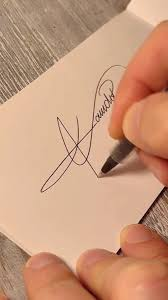il_300x300.5638441675_r6dc.avif

In [15]:
import tensorflow as tf
from tensorflow.keras.models import load_model
@tf.keras.utils.register_keras_serializable()
def euclidean_distance(vectors):
    x, y = vectors
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

model_path = "/content/siamese_model(5).h5"
siamese = load_model(model_path, compile=False, custom_objects={'euclidean_distance': euclidean_distance})
print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
# siamese.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
def preprocess_and_combine_fixed(image_path):
    original_image =   cv2.imread(image_path, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    if original_image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    original_image = cv2.resize(original_image, (128, 128), interpolation=cv2.INTER_AREA)
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    thresholded_image = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 7
    )
    inverted_image = cv2.bitwise_not(thresholded_image)
    kernel = np.ones((2, 2), np.uint8)
    cleaned_image = cv2.morphologyEx(inverted_image, cv2.MORPH_OPEN, kernel)
    preprocessed_image = cleaned_image.astype("float32") / 255.0
    return preprocessed_image

# **Deoloyment**

In [7]:
!pip install flask pyngrok opencv-python-headless tensorflow

In [24]:
import os
import cv2
import numpy as np
import tensorflow as tf
import sqlite3
from flask import Flask, request, render_template_string, jsonify
from pyngrok import ngrok
import base64
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from flask import Flask, request, jsonify, redirect, url_for, render_template_string

app = Flask(__name__)
ngrok.set_auth_token('2feTTlkc3MwE8uIJWWxU5M4WRVC_7FhdKJQXYdDY7akug4zJn')
def init_db():
    conn = sqlite3.connect('/content/signatures.db')
    cursor = conn.cursor()
    cursor.execute('''CREATE TABLE IF NOT EXISTS users (
                        id INTEGER PRIMARY KEY AUTOINCREMENT,
                        username TEXT NOT NULL,
                        original_signature BLOB NOT NULL)''')
    cursor.execute('''CREATE TABLE IF NOT EXISTS signatures (
                        id INTEGER PRIMARY KEY AUTOINCREMENT,
                        username TEXT NOT NULL,
                        signature BLOB NOT NULL,
                        FOREIGN KEY (username) REFERENCES users(username))''')
    conn.commit()
    conn.close()






def preprocess_signature(signature_bytes):
    nparr = np.frombuffer(signature_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
    img = img.astype("float32") / 255.0
    img = img.reshape(128, 128, 1)
    return img


def load_siamese_model():
    model_path = "/content/siamese_model(5).h5"
    return tf.keras.models.load_model(model_path, compile=False, custom_objects={'euclidean_distance': euclidean_distance})
model_path = "/content/siamese_model(5).h5"
siamese = tf.keras.models.load_model(model_path, compile=False, custom_objects={'euclidean_distance': euclidean_distance})

init_db()

def preprocess_image_for_model(image_path):
    original_image = cv2.imread(image_path, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    if original_image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    original_image = cv2.resize(original_image, (128, 128), interpolation=cv2.INTER_AREA)
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    thresholded_image = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 7
    )
    inverted_image = cv2.bitwise_not(thresholded_image)
    kernel = np.ones((2, 2), np.uint8)
    cleaned_image = cv2.morphologyEx(inverted_image, cv2.MORPH_OPEN, kernel)
    preprocessed_image = cleaned_image.astype("float32") / 255.0
    preprocessed_image = preprocessed_image.reshape(128, 128, 1)
    return preprocessed_image

@app.route('/')
def home():
    return render_template_string('''
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Signature Verification System</title>
        <style>
            * {
                margin: 0;
                padding: 0;
                box-sizing: border-box;
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            }

            body {
                min-height: 100vh;
                background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);
                display: flex;
                justify-content: center;
                align-items: center;
                padding: 20px;
            }

            .container {
                background: white;
                border-radius: 20px;
                box-shadow: 0 8px 24px rgba(0,0,0,0.1);
                padding: 40px;
                width: 100%;
                max-width: 800px;
            }

            h1 {
                color: #2c3e50;
                text-align: center;
                margin-bottom: 40px;
                font-size: 2.5rem;
            }

            .methods-container {
                display: grid;
                grid-template-columns: repeat(2, 1fr);
                gap: 30px;
                margin-bottom: 40px;
            }

            .method-card {
                background: #f8fafc;
                border-radius: 15px;
                padding: 30px;
                text-align: center;
                transition: transform 0.3s ease, box-shadow 0.3s ease;
                cursor: pointer;
            }

            .method-card:hover {
                transform: translateY(-5px);
                box-shadow: 0 5px 15px rgba(0,0,0,0.1);
            }

            .method-card h2 {
                color: #2c3e50;
                margin-bottom: 20px;
                font-size: 1.5rem;
            }

            .buttons-container {
                display: grid;
                gap: 15px;
            }

            .btn {
                background: #4CAF50;
                color: white;
                padding: 15px 25px;
                border: none;
                border-radius: 10px;
                font-size: 1rem;
                cursor: pointer;
                transition: background 0.3s ease;
                text-decoration: none;
                display: block;
                text-align: center;
            }

            .btn:hover {
                background: #45a049;
            }

            @media (max-width: 768px) {
                .methods-container {
                    grid-template-columns: 1fr;
                }

                .container {
                    padding: 20px;
                }

                h1 {
                    font-size: 2rem;
                }
            }
        </style>
    </head>
    <body>
        <div class="container">
            <h1>Signature Verification System</h1>
            <div class="methods-container">
                <div class="method-card">
                    <h2>Draw Signature</h2>
                    <div class="buttons-container">
                        <a href="{{ url_for('register') }}" class="btn">Register New Signature</a>
                        <a href="{{ url_for('verify') }}" class="btn">Verify Signature</a>
                    </div>
                </div>
                <div class="method-card">
                    <h2>Upload Image</h2>
                    <div class="buttons-container">
                        <a href="{{ url_for('register_photo') }}" class="btn">Register New Signature</a>
                        <a href="{{ url_for('verify_photo') }}" class="btn">Verify Signature</a>
                    </div>
                </div>
            </div>
        </div>
    </body>
    </html>
    ''')

@app.route('/register', methods=['GET', 'POST'])
def register():
    if request.method == 'POST':
        username = request.form.get('username')
        signature_data = request.form.get('signature')

        if not username or not signature_data:
            return jsonify({"error": "Username and signature are required"}), 400

        signature_bytes = base64.b64decode(signature_data.split(',')[1])
        processed_signature = preprocess_signature(signature_bytes)

        conn = sqlite3.connect('signatures.db')
        cursor = conn.cursor()
        cursor.execute("INSERT INTO signatures (username, signature) VALUES (?, ?)",
                      (username, processed_signature.tobytes()))
        conn.commit()
        conn.close()

        return jsonify({"status": "success"})

    return render_template_string('''
    <!DOCTYPE html>
    <html>
    <head>
        <title>Register Signature</title>
        <style>
            * {
                margin: 0;
                padding: 0;
                box-sizing: border-box;
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            }

            body {
                min-height: 100vh;
                background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);
                display: flex;
                justify-content: center;
                align-items: center;
                padding: 20px;
            }

            .container {
                background: white;
                border-radius: 20px;
                box-shadow: 0 8px 24px rgba(0,0,0,0.1);
                padding: 40px;
                width: 100%;
                max-width: 800px;
            }

            h2 {
                color: #2c3e50;
                text-align: center;
                margin-bottom: 30px;
            }

            canvas {
                border: 2px solid #4CAF50;
                border-radius: 10px;
                margin-bottom: 20px;
                background: white;
                display: block;
                margin: 0 auto 20px;
            }

            .controls {
                display: flex;
                gap: 10px;
                margin-bottom: 20px;
                justify-content: center;
            }

            .btn {
                background: #4CAF50;
                color: white;
                padding: 12px 24px;
                border: none;
                border-radius: 8px;
                font-size: 1rem;
                cursor: pointer;
                transition: background 0.3s ease;
                min-width: 120px;
            }

            .btn:hover {
                background: #45a049;
            }

            input[type="text"] {
                width: 100%;
                padding: 12px;
                margin-bottom: 20px;
                border: 2px solid #ddd;
                border-radius: 8px;
                font-size: 1rem;
            }

            .back-btn {
                display: block;
                text-align: center;
                margin-top: 20px;
                color: #4CAF50;
                text-decoration: none;
            }
        </style>
    </head>
    <body>
        <div class="container">
            <h2>Register Your Signature</h2>
            <canvas id="signatureCanvas" width="400" height="200"></canvas>
            <div class="controls">
                <button class="btn" onclick="clearCanvas()">Clear</button>
                <button class="btn" onclick="undoLast()">Undo</button>
            </div>
            <input type="text" id="username" placeholder="Enter your username" required>
            <button class="btn" onclick="saveSignature()">Save Signature</button>
            <a href="{{ url_for('home') }}" class="back-btn">Back to Home</a>
        </div>

        <script>
            const canvas = document.getElementById('signatureCanvas');
            const ctx = canvas.getContext('2d');
            let isDrawing = false;
            let paths = [];
            let currentPath = [];

            ctx.fillStyle = 'white';
            ctx.fillRect(0, 0, canvas.width, canvas.height);

            canvas.addEventListener('mousedown', startDrawing);
            canvas.addEventListener('mousemove', draw);
            canvas.addEventListener('mouseup', stopDrawing);
            canvas.addEventListener('mouseout', stopDrawing);

            function startDrawing(e) {
                isDrawing = true;
                currentPath = [];
                const point = {
                    x: e.offsetX,
                    y: e.offsetY
                };
                currentPath.push(point);
            }

            function draw(e) {
                if (!isDrawing) return;

                const point = {
                    x: e.offsetX,
                    y: e.offsetY
                };
                currentPath.push(point);

                ctx.strokeStyle = 'black';
                ctx.lineWidth = 2;
                ctx.lineCap = 'round';

                ctx.beginPath();
                ctx.moveTo(currentPath[0].x, currentPath[0].y);
                for (let i = 1; i < currentPath.length; i++) {
                    ctx.lineTo(currentPath[i].x, currentPath[i].y);
                }
                ctx.stroke();
            }

            function stopDrawing() {
                if (isDrawing && currentPath.length > 0) {
                    paths.push(currentPath);
                }
                isDrawing = false;
            }

            function clearCanvas() {
                ctx.fillStyle = 'white';
                ctx.fillRect(0, 0, canvas.width, canvas.height);
                paths = [];
                currentPath = [];
            }

            function undoLast() {
                if (paths.length > 0) {
                    paths.pop();
                    redrawCanvas();
                }
            }

            function redrawCanvas() {
                ctx.fillStyle = 'white';
                ctx.fillRect(0, 0, canvas.width, canvas.height);

                ctx.strokeStyle = 'black';
                ctx.lineWidth = 2;
                ctx.lineCap = 'round';

                paths.forEach(path => {
                    ctx.beginPath();
                    ctx.moveTo(path[0].x, path[0].y);
                    for (let i = 1; i < path.length; i++) {
                        ctx.lineTo(path[i].x, path[i].y);
                    }
                    ctx.stroke();
                });
            }

            function saveSignature() {
                const username = document.getElementById('username').value;
                if (!username) {
                    alert('Please enter a username');
                    return;
                }
                const signatureData = canvas.toDataURL('image/png');

                fetch('/register', {
                    method: 'POST',
                    headers: {
                        'Content-Type': 'application/x-www-form-urlencoded',
                    },
                    body: `username=${username}&signature=${encodeURIComponent(signatureData)}`
                })
                .then(response => response.json())
                .then(data => {
                    if (data.status === 'success') {
                        alert('Signature registered successfully');
                        window.location.href = '/';
                    }
                });
            }
        </script>
    </body>
    </html>
    ''')

@app.route('/verify', methods=['GET', 'POST'])
def verify():
    if request.method == 'POST':
        username = request.form.get('username')
        signature_data = request.form.get('signature')

        if not username or not signature_data:
            return jsonify({"error": "Username and signature are required"}), 400

        signature_bytes = base64.b64decode(signature_data.split(',')[1])
        processed_signature = preprocess_signature(signature_bytes)

        conn = sqlite3.connect('signatures.db')
        cursor = conn.cursor()
        cursor.execute("SELECT signature FROM signatures WHERE username=?", (username,))
        stored_signatures = cursor.fetchall()
        conn.close()

        if not stored_signatures:
            return jsonify({"verified": False, "message": "No registered signature found for this username"}), 404

        best_similarity = 0
        for stored_sig_bytes in stored_signatures:
            stored_sig = np.frombuffer(stored_sig_bytes[0], dtype=np.float32).reshape(128, 128, 1)
            sig1 = np.expand_dims(stored_sig, axis=0)
            sig2 = np.expand_dims(processed_signature, axis=0)
            distance = siamese_model.predict([sig1, sig2])
            similarity_score = 1 - float(distance)
            best_similarity = max(best_similarity, similarity_score)

        return jsonify({
            "verified": best_similarity > 0.85,
            "message": "Original" if best_similarity > 0.85 else "Fake",
            "similarity": float(best_similarity)
        })

    return render_template_string('''
    <!DOCTYPE html>
    <html>
    <head>
        <title>Verify Signature</title>
        <style>
            * {
                margin: 0;
                padding: 0;
                box-sizing: border-box;
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            }

            body {
                min-height: 100vh;
                background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);
                display: flex;
                justify-content: center;
                align-items: center;
                padding: 20px;
            }

            .container {
                background: white;
                border-radius: 20px;
                box-shadow: 0 8px 24px rgba(0,0,0,0.1);
                padding: 40px;
                width: 100%;
                max-width: 800px;
            }

            h2 {
                color: #2c3e50;
                text-align: center;
                margin-bottom: 30px;
            }

            canvas {
                border: 2px solid #4CAF50;
                border-radius: 10px;
                margin-bottom: 20px;
                background: white;
                display: block;
                margin: 0 auto 20px;
            }

            .controls {
                display: flex;
                gap: 10px;
                margin-bottom: 20px;
                justify-content: center;
            }

            .btn {
                background: #4CAF50;
                color: white;
                padding: 12px 24px;
                border: none;
                border-radius: 8px;
                font-size: 1rem;
                cursor: pointer;
                transition: background 0.3s ease;
                min-width: 120px;
            }

            .btn:hover {
                background: #45a049;
            }

            input[type="text"] {
                width: 100%;
                padding: 12px;
                margin-bottom: 20px;
                border: 2px solid #ddd;
                border-radius: 8px;
                font-size: 1rem;
            }

            .result {
                margin-top: 20px;
                padding: 15px;
                border-radius: 8px;
                text-align: center;
                display: none;
            }

            .result.success {
                background: #d4edda;
                color: #155724;
            }

            .result.error {
                background: #f8d7da;
                color: #721c24;
            }

            .back-btn {
                display: block;
                text-align: center;
                margin-top: 20px;
                color: #4CAF50;
                text-decoration: none;
            }
        </style>
    </head>
    <body>
        <div class="container">
            <h2>Verify Signature</h2>
            <canvas id="signatureCanvas" width="400" height="200"></canvas>
            <div class="controls">
                <button class="btn" onclick="clearCanvas()">Clear</button>
                <button class="btn" onclick="undoLast()">Undo</button>
            </div>
            <input type="text" id="username" placeholder="Enter username to verify" required>
            <button class="btn" onclick="verifySignature()">Verify Signature</button>
            <div id="result" class="result"></div>
            <a href="{{ url_for('home') }}" class="back-btn">Back to Home</a>
        </div>

        <script>
            const canvas = document.getElementById('signatureCanvas');
            const ctx = canvas.getContext('2d');
            let isDrawing = false;
            let paths = [];
            let currentPath = [];

            ctx.fillStyle = 'white';
            ctx.fillRect(0, 0, canvas.width, canvas.height);

            canvas.addEventListener('mousedown', startDrawing);
            canvas.addEventListener('mousemove', draw);
            canvas.addEventListener('mouseup', stopDrawing);
            canvas.addEventListener('mouseout', stopDrawing);

            function startDrawing(e) {
                isDrawing = true;
                currentPath = [];
                const point = {
                    x: e.offsetX,
                    y: e.offsetY
                };
                currentPath.push(point);
            }

            function draw(e) {
                if (!isDrawing) return;

                const point = {
                    x: e.offsetX,
                    y: e.offsetY
                };
                currentPath.push(point);

                ctx.strokeStyle = 'black';
                ctx.lineWidth = 2;
                ctx.lineCap = 'round';

                ctx.beginPath();
                ctx.moveTo(currentPath[0].x, currentPath[0].y);
                for (let i = 1; i < currentPath.length; i++) {
                    ctx.lineTo(currentPath[i].x, currentPath[i].y);
                }
                ctx.stroke();
            }

            function stopDrawing() {
                if (isDrawing && currentPath.length > 0) {
                    paths.push(currentPath);
                }
                isDrawing = false;
            }

            function clearCanvas() {
                ctx.fillStyle = 'white';
                ctx.fillRect(0, 0, canvas.width, canvas.height);
                paths = [];
                currentPath = [];
            }

            function undoLast() {
                if (paths.length > 0) {
                    paths.pop();
                    redrawCanvas();
                }
            }

            function redrawCanvas() {
                ctx.fillStyle = 'white';
                ctx.fillRect(0, 0, canvas.width, canvas.height);

                ctx.strokeStyle = 'black';
                ctx.lineWidth = 2;
                ctx.lineCap = 'round';

                paths.forEach(path => {
                    ctx.beginPath();
                    ctx.moveTo(path[0].x, path[0].y);
                    for (let i = 1; i < path.length; i++) {
                        ctx.lineTo(path[i].x, path[i].y);
                    }
                    ctx.stroke();
                });
            }

            function verifySignature() {
                const username = document.getElementById('username').value;
                if (!username) {
                    alert('Please enter a username');
                    return;
                }
                const signatureData = canvas.toDataURL('image/png');

                fetch('/verify', {
                    method: 'POST',
                    headers: {
                        'Content-Type': 'application/x-www-form-urlencoded',
                    },
                    body: `username=${username}&signature=${encodeURIComponent(signatureData)}`
                })
                .then(response => response.json())
                .then(data => {
                    const resultDiv = document.getElementById('result');
                    resultDiv.style.display = 'block';
                    resultDiv.className = `result ${data.verified ? 'success' : 'error'}`;
                    resultDiv.textContent = `Verification Result: ${data.message} (Similarity: ${(data.similarity * 100).toFixed(2)}%)`;
                });
            }
        </script>
    </body>
    </html>
    ''')

@app.route('/register_photo', methods=['GET', 'POST'])
def register_photo():
    if request.method == 'POST':
        username = request.form.get('username')
        image = request.files.get('image')

        if not username or not image:
            return jsonify({"error": "Username and image are required"}), 400

        os.makedirs('uploads', exist_ok=True)
        image_path = os.path.join('uploads', f'{username}_signature.png')
        image.save(image_path)

        processed_image = preprocess_image_for_model(image_path)

        conn = sqlite3.connect('signatures.db')
        cursor = conn.cursor()
        cursor.execute("INSERT INTO signatures (username, signature) VALUES (?, ?)",
                      (username, processed_image.tobytes()))
        conn.commit()
        conn.close()

        return redirect(url_for('home'))

    return render_template_string('''
    <!DOCTYPE html>
    <html>
    <head>
        <title>Register Photo Signature</title>
        <style>
            * {
                margin: 0;
                padding: 0;
                box-sizing: border-box;
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            }

            body {
                min-height: 100vh;
                background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);
                display: flex;
                justify-content: center;
                align-items: center;
                padding: 20px;
            }

            .container {
                background: white;
                border-radius: 20px;
                box-shadow: 0 8px 24px rgba(0,0,0,0.1);
                padding: 40px;
                width: 100%;
                max-width: 800px;
            }

            h2 {
                color: #2c3e50;
                text-align: center;
                margin-bottom: 30px;
            }

            .form-group {
                margin-bottom: 20px;
            }

            label {
                display: block;
                margin-bottom: 8px;
                color: #2c3e50;
            }

            input[type="text"],
            input[type="file"] {
                width: 100%;
                padding: 12px;
                border: 2px solid #ddd;
                border-radius: 8px;
                font-size: 1rem;
            }

            .btn {
                background: #4CAF50;
                color: white;
                padding: 12px 24px;
                border: none;
                border-radius: 8px;
                font-size: 1rem;
                cursor: pointer;
                transition: background 0.3s ease;
                width: 100%;
            }

            .btn:hover {
                background: #45a049;
            }

            .back-btn {
                display: block;
                text-align: center;
                margin-top: 20px;
                color: #4CAF50;
                text-decoration: none;
            }
        </style>
    </head>
    <body>
        <div class="container">
            <h2>Register Photo Signature</h2>
            <form action="{{ url_for('register_photo') }}" method="post" enctype="multipart/form-data">
                <div class="form-group">
                    <label for="username">Username:</label>
                    <input type="text" id="username" name="username" required>
                </div>
                <div class="form-group">
                    <label for="image">Upload Signature Image:</label>
                    <input type="file" id="image" name="image" accept="image/*" required>
                </div>
                <button type="submit" class="btn">Register Signature</button>
            </form>
            <a href="{{ url_for('home') }}" class="back-btn">Back to Home</a>
        </div>
    </body>
    </html>
    ''')

@app.route('/verify_photo', methods=['GET', 'POST'])

def verify_photo():
    if request.method == 'POST':
        username = request.form.get('username')
        image_2 = request.files.get('image_2')

        if not username or not image_2:
            return jsonify({"error": "Username and signature are required"}), 400

        os.makedirs('uploads', exist_ok=True)
        image_2_path = os.path.join('uploads', f'{username}_verify.png')
        image_2.save(image_2_path)
        processed_image_2 = preprocess_image_for_model(image_2_path)
        processed_image_2_flattened = processed_image_2.flatten()
        conn = sqlite3.connect('signatures.db')
        cursor = conn.cursor()
        cursor.execute("SELECT signature FROM signatures WHERE username=?", (username,))
        rows = cursor.fetchall()
        if not rows:
            return jsonify({"error": "No signatures found for this username"}), 404
        best_match = None
        best_similarity = 0
        for row in rows:
            original_signature = np.frombuffer(row[0], dtype=np.float32).reshape(128, 128, 1)
            signature_1 = np.expand_dims(original_signature, axis=0)
            signature_2 = np.expand_dims(processed_image_2, axis=0)
            signature_1 = np.tile(signature_1, (1, 1, 1, 1))
            signature_2 = np.tile(signature_2, (1, 1, 1, 1))
            distance = siamese([signature_1, signature_2])
            similarity_score = 1 - float(distance.numpy())
            if similarity_score > best_similarity:
                best_similarity = similarity_score
                best_match = row

        result = "True" if best_similarity > 0.899 else "Fake"
        return render_template_string("""
        <!doctype html>
        <html lang="en">
        <head>
            <meta charset="UTF-8">
            <meta name="viewport" content="width=device-width, initial-scale=1.0">
            <title>Verification Result</title>
            <link href="https://fonts.googleapis.com/css2?family=Roboto:wght@300;400;500&display=swap" rel="stylesheet">
            <style>
                body {
                    font-family: 'Roboto', sans-serif;
                    background: #f5f5f5;
                    margin: 0;
                    padding: 0;
                    display: flex;
                    justify-content: center;
                    align-items: center;
                    height: 100vh;
                }
                .container {
                    background-color: white;
                    border-radius: 10px;
                    padding: 40px;
                    box-shadow: 0 4px 12px rgba(0, 0, 0, 0.1);
                    width: 90%;
                    max-width: 600px;
                    text-align: center;
                }
                h1 {
                    color: #4CAF50;
                    font-size: 2.5rem;
                    margin-bottom: 20px;
                }
                p {
                    font-size: 1.2rem;
                    margin-bottom: 20px;
                }
                .result {
                    font-size: 1.5rem;
                    font-weight: bold;
                    color: {{ 'red' if result == 'Fake' else 'green' }};
                }
                a {
                    text-decoration: none;
                    color: #4CAF50;
                    font-size: 1.2rem;
                    margin-top: 20px;
                    display: inline-block;
                }
            </style>
        </head>
        <body>
            <div class="container">
                <h1>Verification Result</h1>
                <p>Similarity Score: {{ best_similarity }}</p>
                <p class="result">The signature is: {{ result }}</p>
                <a href="{{ url_for('home') }}">Go Back to Home</a>
            </div>
        </body>
        </html>
        """, best_similarity=best_similarity, result=result)
    return render_template_string("""
    <!doctype html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Signature Verification</title>
        <style>
            body {
                font-family: 'Roboto', sans-serif;
                background: #f5f5f5;
                padding: 0;
                text-align: center;
            }
            .container {
                background-color: white;
                border-radius: 10px;
                padding: 40px;
                box-shadow: 0 4px 12px rgba(0, 0, 0, 0.1);
                max-width: 600px;
                margin: auto;
            }
            h1 {
                color: #4CAF50;
                font-size: 2.5rem;
                margin-bottom: 20px;
            }
            label, input {
                width: 100%;
                padding: 12px;
                margin: 10px 0;
                border: 1px solid #ddd;
            }
            input[type="file"] {
                padding: 10px;
            }
            input[type="submit"] {
                background-color: #4CAF50;
                color: white;
                border: none;
                border-radius: 5px;
                padding: 15px;
                cursor: pointer;
            }
        </style>
    </head>
    <body>
        <div class="container">
            <h1>Signature Verification</h1>
            <form method="post" enctype="multipart/form-data">
                <label for="username">Username:</label>
                <input type="text" name="username" required>
                <label for="image_2">Upload Signature to Verify:</label>
                <input type="file" name="image_2" required>
                <input type="submit" value="Verify">
            </form>
        </div>
    </body>
    </html>
    """)
import os
import cv2
import numpy as np
import tensorflow as tf
import sqlite3
from flask import Flask, request, render_template_string, jsonify
from pyngrok import ngrok
import base64
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from flask import Flask, request, jsonify, redirect, url_for, render_template_string
import socket
def get_open_port():
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.bind(("", 0))
    port = sock.getsockname()[1]
    sock.close()
    return port

if __name__ == "__main__":
    port = get_open_port()
    ngrok_tunnel = ngrok.connect(port)
    print('NGROK Tunnel URL:', ngrok_tunnel.public_url)
    app.run(port=port)

NGROK Tunnel URL: https://09ea-34-125-53-119.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:57233
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [30/Jan/2025 16:48:02] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [30/Jan/2025 16:48:02] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [30/Jan/2025 16:48:03] "GET /register_photo HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [30/Jan/2025 16:48:18] "POST /register_photo HTTP/1.1" 302 -
INFO:werkzeug:127.0.0.1 - - [30/Jan/2025 16:48:18] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [30/Jan/2025 16:48:21] "GET /verify_photo HTTP/1.1" 200 -
<ipython-input-24-0aed758054ac>:860: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  similarity_score = 1 - float(distance.n

**# Test for first data set after save our model**

In [ ]:
# import tensorflow.keras as keras
# import numpy as np
# import pandas as pd
# import os
# import cv2
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

# test_dir = "/content/Dataset 1/sign_data/test"
# test_csv = "/content/Dataset 1/sign_data/test_data.csv"

# test_data = pd.read_csv(test_csv, header=None, names=["image1", "image2", "label"])
# preprocessed_test_data = []
# test_labels = []
# for idx, row in test_data.iterrows():
#     img1_path = os.path.join(test_dir, row["image1"])
#     img2_path = os.path.join(test_dir, row["image2"])
#     try:
#         img1 = preprocess_and_combine_fixed(img1_path)
#         img2 = preprocess_and_combine_fixed(img2_path)
#         preprocessed_test_data.append((img1, img2))
#         test_labels.append(row["label"])
#     except FileNotFoundError as e:
#         print(e)
# preprocessed_test_data = np.array(preprocessed_test_data)
# test_labels = np.array(test_labels, dtype="float32")

# print(f"Preprocessed test data shape: {preprocessed_test_data.shape}")
# print(f"Test labels shape: {test_labels.shape}")


# x_test_1 = preprocessed_test_data[:, 0].reshape(-1, 128, 128, 1)
# x_test_2 = preprocessed_test_data[:, 1].reshape(-1, 128, 128, 1)


# test_loss, test_accuracy = siamese.evaluate([x_test_1, x_test_2], test_labels, batch_size=32)
# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")




Preprocessed test data shape: (5748, 2, 128, 128)
Test labels shape: (5748,)
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.1654
Test Loss: 0.16464802622795105
Test Accuracy: 1.0


In [ ]:
# test_loss, test_accuracy = siamese.evaluate([x_test_1, x_test_2], test_labels, batch_size=32)
# print(f"Test Loss: {test_loss}")
# print(f"Test Accuracy: {test_accuracy}")

180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 0.1654
Test Loss: 0.16464802622795105
Test Accuracy: 1.0


**# Test for second data set after save our model**

In [ ]:
# import tensorflow.keras as keras
# import numpy as np
# import pandas as pd
# import os
# import cv2
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

# test_dataset = pd.read_csv('/content/signature-verification-dataset-iraninan.csv.xls', header=None, skiprows=1)
# test_dir = "/content/Dataset_test 2"
# def load_image(image_path, target_size=(128, 128)):
#     try:
#         full_path = os.path.join(test_dir, image_path)
#         if not os.path.exists(full_path):
#             raise FileNotFoundError(f"Image not found: {full_path}")
#         image = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
#         if image is None:
#             raise ValueError(f"Failed to read image: {full_path}")
#         return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
#     except Exception as e:
#         print(f"Error loading image: {e}")
#         return None

# def evaluate_siamese_model(dataset, model):
#     X1 = []
#     X2 = []
#     y = []

#     for i in range(len(dataset)):
#         row = dataset.iloc[i]
#         img1 = load_image(row[0])
#         img2 = load_image(row[1])
#         if img1 is None or img2 is None:
#             print(f"Skipping invalid pair: {row[0]}, {row[1]}")
#             continue
#         X1.append(img1)
#         X2.append(img2)
#         y.append(row[2])


#     X1 = np.array(X1, dtype=np.float32)
#     X2 = np.array(X2, dtype=np.float32)
#     y = np.array(y, dtype=np.float32)


#     X1 = np.expand_dims(X1, axis=-1)
#     X2 = np.expand_dims(X2, axis=-1)


#     loss, accuracy = model.evaluate([X1, X2], y, verbose=1)
#     print(f"Test Loss: {loss:.4f}")
#     print(f"Test Accuracy: {accuracy:.4f}")
# evaluate_siamese_model(test_dataset, siamese)

150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7282 - loss: 0.7623
Test Loss: 0.8644
Test Accuracy: 0.6792


**# Test for third data set after save our model**

In [ ]:
# import tensorflow.keras as keras
# import numpy as np
# import pandas as pd
# import os
# import cv2
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam


# test_dataset = pd.read_csv('/content/signature-forgery-dataset_test.csv.xls', header=None, skiprows=2)


# test_dir = "/content/Dataset_test 3"


# def load_image(image_path, target_size=(128, 128)):
#     try:
#         full_path = os.path.join(test_dir, image_path)
#         if not os.path.exists(full_path):
#             raise FileNotFoundError(f"Image not found: {full_path}")
#         image = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
#         if image is None:
#             raise ValueError(f"Failed to read image: {full_path}")
#         return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
#     except Exception as e:
#         print(f"Error loading image: {e}")
#         return None

# def evaluate_siamese_model(dataset, model):
#     X1 = []
#     X2 = []
#     y = []

#     for i in range(len(dataset)):
#         row = dataset.iloc[i]
#         img1 = load_image(row[0])
#         img2 = load_image(row[1])
#         if img1 is None or img2 is None:
#             print(f"Skipping invalid pair: {row[0]}, {row[1]}")
#             continue


#         X1.append(img1)
#         X2.append(img2)
#         y.append(row[2])


#     X1 = np.array(X1, dtype=np.float32)
#     X2 = np.array(X2, dtype=np.float32)
#     y = np.array(y, dtype=np.float32)


#     X1 = np.expand_dims(X1, axis=-1)
#     X2 = np.expand_dims(X2, axis=-1)

#     loss, accuracy = model.evaluate([X1, X2], y, verbose=1)
#     print(f"Test Loss: {loss:.4f}")
#     print(f"Test Accuracy: {accuracy:.4f}")

# evaluate_siamese_model(test_dataset, siamese)

242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7298 - loss: 0.7747
Test Loss: 0.9267
Test Accuracy: 0.6720
